# Sensor Placement algorithms and the Parameterised Background Data-Weak (PBDW) approach

This notebook presents some sensor placement algorithms implemented in the *pyforce* library, such as the Empirical Interpolation Method (EIM), the Generalised Empirical Interpolation Method (GEIM) and the SGreedy algorithm. These algorithms are used to select the optimal locations for sensors in order to reconstruct a field of interest from a limited number of measurements. The EIM and GEIM are based on the idea of selecting the most informative points in the domain, while the SGreedy algorithm is based on a greedy approach that iteratively selects the best sensor location based on a given criterion.

Once sensors are placed, they can be used to predict unknown states from a test set using the EIM, GEIM and the Parameterised Background Data-Weak (PBDW) approach, this latter technique is based on the combination of a reduced model and the observations from sensors and can be considered a general framework for data assimilation and reduced order modelling.

In this tutorial, you will learn:

- How to import data from *dolfinx* 
- How to use the EIM and GEIM algorithms for sensor placement
- How to use the SGreedy algorithm for sensor placement
- How to use the EIM, GEIM and PBDW approaches for state estimation

The data for this tutorial comes from a [OFELIA](https://github.com/ERMETE-Lab/MP-OFELIA) tutorial, the ANL11A2 reactor inspired from the benchmark of Argonne National Laboratory [https://www.osti.gov/servlets/purl/12030251/](https://www.osti.gov/servlets/purl/12030251/) in which two-group neutron diffusion is used to model the neutron economy in a portion of a 2D PWR reactor core. The data have been generated using the [dolfinx-v6](https://fenicsproject.org/) package, using solvers implemented within OFELIA. The interested reader can refer to the [OFELIA documentation](https://ermete-lab.github.io/MP-OFELIA/) for more details about the mathematical model and the numerical methods used to solve it.

## Import dolfinx (v6) case from npz files

The data are parametric with respect to the fast diffusion coefficient in the reflection and the thermal absorption cross section in a rod region. The snaphots of the fast and thermal fluxes are stored in an `npz` file, which can be loaded using `numpy.load`. 

Each variable is stored as a 2D array, where each column represents a snapshot at a given parameter value, and each row represents a spatial point in the domain.

The code below works for all the variables in the dataset, and it will be chosen just one of them for the sensor placement.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

_data = np.load('Datasets/ANL11A2_dolfinx6/anl11a2.npz', allow_pickle=True)

var_names = _data.files
print(f"Available variables: {var_names}")

from pyforce.tools.functions_list import FunctionsList
field = var_names[0] # selected field
dataset = FunctionsList(snap_matrix=_data[field])

import pandas as pd
parameters = np.load('Datasets/ANL11A2_dolfinx6/params_anl11a2.npy', allow_pickle=True)
parameters_key = ['D_1_refl', 'k_eff', 'xs_a_2_rod'] # Column names

Available variables: ['phi_1', 'phi_2']


The parameters include the fast diffusion coefficient in the reflector, $D_{1,ref}$, the thermal absorption cross section in a rod region, $\Sigma_{a,2,rod}$, and the associated effective multiplication factor calculation with neutron diffusion theory, $k_{eff}$.

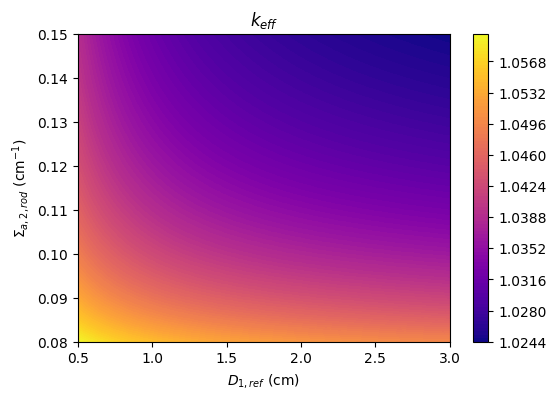

In [2]:
fig, axs = plt.subplots(figsize=(6,4))

c = axs.tricontourf(
    parameters[:, 0], parameters[:, 2], parameters[:, 1], levels=100, cmap="plasma"
)

axs.set_xlabel(r'$D_{1,ref}$ (cm)')
axs.set_ylabel(r'$\Sigma_{a,2,rod}$ (cm$^{-1}$)')
axs.set_title(r'$k_{eff}$')
fig.colorbar(c, ax=axs)

Let us also load the grid from a VTK file.

In [3]:
import pyvista as pv
grid = pv.read('Datasets/ANL11A2_dolfinx6/mesh_anl11a2.vtk')
gdim = 2
grid

UnstructuredGrid,Information
N Cells,13380
N Points,6869
X Bounds,"0.000e+00, 1.700e+02"
Y Bounds,"0.000e+00, 1.300e+02"
Z Bounds,"0.000e+00, 0.000e+00"
N Arrays,0


Let us make a plot of the snapshots

In [4]:
# field = 'phi_1'
# dataset[field].plot_sequence(grid, sampling = 20, title=field+' id = ', title_size=15, resolution=[700,600], cmap='jet', varname=field)

Let us split the dataset into a training and a test set

In [5]:
from pyforce.tools.functions_list import train_test_split
train_params, test_params, train_snaps, test_snaps = train_test_split(
    parameters, dataset, test_size=0.33, random_state=42
)

## Sensor placement algorithms
In this section, the focus will be on the implementation of sensor placement algorithms: in particular, it will be shown how to place sensors based on some candidate locations (constrained to a portion of the domain).

Text(0, 0.5, 'y (cm)')

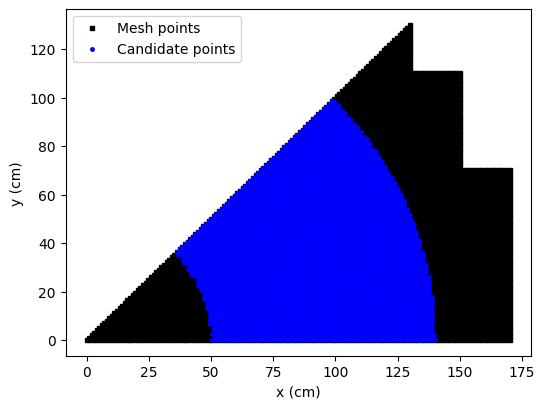

In [6]:
def is_external(point):
    # if np.linalg.norm(point) >= 150:
    if np.linalg.norm(point) >= 50 and np.linalg.norm(point) <=140:
        return True
    return False

candidate_idx = np.arange(len(grid.points))
candidate_idx = [i for i in candidate_idx if is_external(grid.points[i])]
candidate_points = [np.asarray(grid.points[i]) for i in candidate_idx]

fig = plt.figure(figsize=(6,4.5))

mark_size = 2.5
plt.plot(*grid.points.T[:gdim], 'ks', markersize=mark_size, label='Mesh points')
plt.plot([p[0] for p in candidate_points], [p[1] for p in candidate_points], 'bo', markersize=mark_size, label='Candidate points')

plt.legend()
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')

Sensors in the reactor core are not allowed, so we will place sensors only in the reflector region. The candidate locations are represented by the blue points in the figure above.

The EIM, the GEIM and the SGreedy algorithms can be used to place sensors in the reflector region and they will be discussed below.

In [7]:
Mmax = 15

### EIM sensor placement
This algorithm has already been presented in the previous tutorial. The sensor selection is based on a greedy approach, aimed at reducing the interpolation error.

In the previous tutorial, no constraint was imposed on the sensor locations, while here we will use only the candidate locations in the reflector region: the EIM algorithm requires the indices of the candidate locations as input through the `_xm` argument.

In [8]:
from pyforce.offline.eim import EIM

eim_offline = EIM(grid, gdim=gdim, varname=field)
train_eim_coeffs = eim_offline.fit(train_snaps=train_snaps, Mmax = Mmax, 
                                   _xm_idx = candidate_idx, 
                                   verbose=True)[1]

  Iteration 015 | Abs Err (Linfty): 3.03e-05 - EIM done


### GEIM sensor placement
As already mentioned in the previous tutorial, the GEIM algorithm is a generalization of the EIM algorithm, which allows to use linear functionals as sensors. 

Similar to the EIM algorithm, the GEIM algorithm can be constrained to use only a subset of candidate locations. This is done by providing the candidate locations through the `xm_list` entry (not indices but the actual points) of the `sensor_params` dictionary.

In [18]:
from pyforce.offline.geim import GEIM

geim_offline = GEIM(grid, gdim=gdim, varname=field, sensors_type='Gaussian')

sens_params = {
    's': 2, # spread of the Gaussian kernels - hyperparameter to be tuned according to the physical system
     'xm_list': candidate_points[::20], # downsampled candidate points for computational efficiency
}

train_geim_coeff = geim_offline.fit(train_snaps=train_snaps, Mmax = Mmax, 
                                    sensor_params=sens_params, verbose=True)[2]

Creating Gaussian Sensor Library: 100.000 / 100.00% - 0.000832 s/it


### SGreedy sensor placement
The SGreedy algorithm is still considered a greedy approach, generalised to any reduced basis and any linear functional as sensor. In particular, the SGreedy algorithm requires a reduced basis spanning an associated reduced space as input, which can be obtained through a POD of the training snapshots (for instance), then the sensors are selected to maximise the amount of information provided by the sensors spanning an update space of dimension `Mmax`.

At this purpose, let us perform a randomised SVD of the training snapshots.

In [9]:
from pyforce.offline.pod import rSVD

svd_offline = rSVD(grid, gdim=gdim, varname=field)
svd_offline.fit(train_snaps=train_snaps, rank=40, verbose=True)

SVD of phi_1 snapshots calculated in 0.071107 seconds (cpu).


Let us plot the singular values

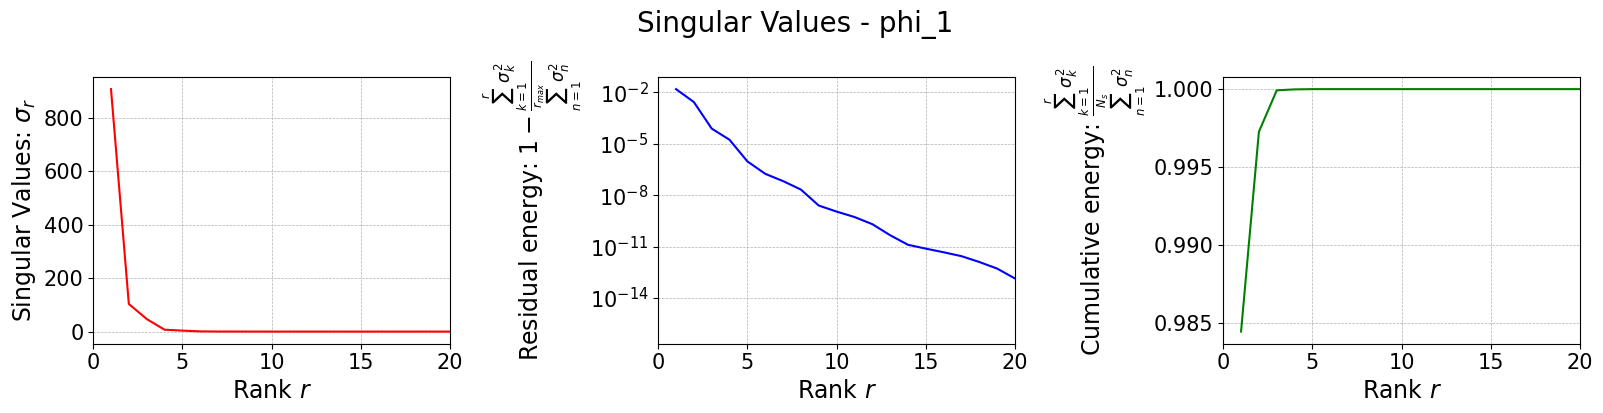

In [10]:
svd_fig = svd_offline.plot_sing_vals()
axs = svd_fig.get_axes()
for ax in axs:
    ax.set_xlim(0,20)

Once the basis is computed, we can use it to perform the SGreedy sensor placement. The initialization of the class is similar to the previous cases.

In [11]:
from pyforce.offline.sgreedy import SGREEDY

sgreedy_placement = SGREEDY(grid, gdim=gdim, varname=field)

The training of the SGreedy algorithm, through the `fit` method, requires the basis functions spanning the reduced space (using only the first 5 modes), the maximum number of sensors to be placed, and the sensor parameters (similar to the GEIM case).

In [12]:
sens_params = {
    's': 2, # spread of the Gaussian kernels - hyperparameter to be tuned according to the physical system
     'xm_list': candidate_points[::20], # downsampled candidate points for computational efficiency
}

rank_svd = 6

sgreedy_placement.fit(
    basis_functions= svd_offline.svd_modes[:rank_svd],
    Mmax = Mmax,
    sensor_params=sens_params
)

Creating Gaussian Sensor Library: 100.000 / 100.00% - 0.000824 s/it


### Comparison of the positions
In the following figure we are going to observe the center of mass of each sensor placed by the three algorithms, along with the candidate locations.

Text(0.5, 1.0, 'SGreedy sensor placement')

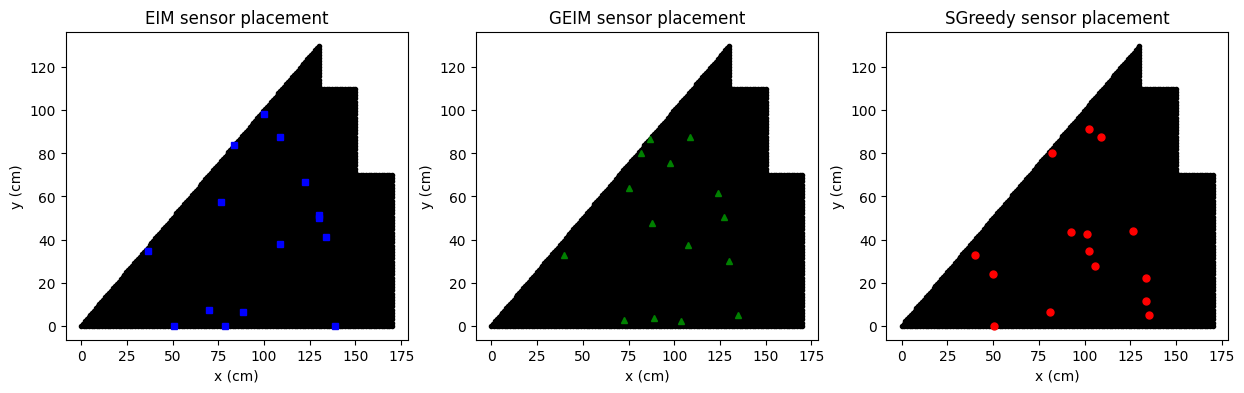

In [19]:
fig, axs = plt.subplots(1,3, figsize=(15,4))

for ax in axs:
    ax.plot(grid.points[:,0], grid.points[:,1], 'ko', markersize=3)
    ax.set_xlabel('x (cm)')
    ax.set_ylabel('y (cm)')

axs[0].plot([p[0] for p in eim_offline.magic_points['points']],
            [p[1] for p in eim_offline.magic_points['points']], 'bs', markersize=5, label='EIM magic points')
axs[1].plot([grid.points[geim_offline.magic_sensors.library(pp).argmax(), 0] for pp in range(len(geim_offline.magic_sensors))],
            [grid.points[geim_offline.magic_sensors.library(pp).argmax(), 1] for pp in range(len(geim_offline.magic_sensors))], 
            'g^', markersize=5, label='GEIM magic points')
axs[2].plot([p[0] for p in sgreedy_placement.sensor_centers],
            [p[1] for p in sgreedy_placement.sensor_centers], 'ro', markersize=5, label='SGreedy sensors')

axs[0].set_title('EIM sensor placement')
axs[1].set_title('GEIM sensor placement')
axs[2].set_title('SGreedy sensor placement')

## Online Phase: prediction of unknown states
The EIM and GEIM have already been presented in the previous tutorial, while the output of the SGreedy algorithm can be used for the Parameterised Background Data-Weak (PBDW) approach, which is a state estimation technique based on the combination of a reduced model and the observations from sensors. This method includes any data-driven reduced order model, such as EIM and GEIM, as a special case: this framework is based on the assumption that the true state can be approximated by a linear combination of a reduced basis (the background space) and an update space spanned by the Riesz representers of the sensors.

In this section, the EIM, GEIM and PBDW approaches will be used to predict unknown states from the test set, using only the sensors placed in the previous section.

In [20]:
noise_std = 0.025

### EIM state estimation
The EIM state estimation is based on the interpolation of the unknown state using the sensors placed by the EIM algorithm.

In [21]:
from pyforce.online.eim import EIM as OnlineEIM

eim_online = OnlineEIM(grid, gdim=gdim, varname=field)
eim_online.set_basis(eim_offline.magic_functions)
eim_online.set_magic_points(eim_offline.magic_points)

# Assemble Tikhonov regularization matrix
eim_online.set_tikhonov_matrices(beta_coeffs=train_eim_coeffs)

# Prediction with EIM
test_eim_measures = eim_online.get_measurements(test_snaps, noise_std=noise_std)
eim_prediction = eim_online.estimate(test_eim_measures, regularization_params={'type': 'tikhonov', 'lambda': noise_std**2})

### GEIM state estimation
The GEIM state estimation is based on the interpolation of the unknown state using the sensors placed by the GEIM algorithm.

In [22]:
from pyforce.online.geim import GEIM as OnlineGEIM

geim_online = OnlineGEIM(grid, gdim=gdim, varname=field)
geim_online.set_basis(geim_offline.magic_functions)
geim_online.set_magic_sensors(geim_offline.magic_sensors.library)

# Assemble Tikhonov regularization matrix
geim_online.set_tikhonov_matrices(beta_coeffs=train_geim_coeff)

# Prediction with GEIM
test_geim_measures = geim_online.get_measurements(test_snaps, noise_std=noise_std)
geim_prediction = geim_online.estimate(test_geim_measures, regularization_params={'type': 'tikhonov', 'lambda': noise_std**2})

### PBDW state estimation
The Parameterised-Background Data-Weak (PBDW) approach is a state estimation technique that combines a reduced model with observations from sensors.
This technique can work with a variety of reduced basis and basis sensors, even randomly placed sensors (expecting not optimal results). This class has been implemented in the `PBDW` class within the `pyforce.online.pbdw` module.

The initialization of the class is similar to the previous cases.

In [23]:
from pyforce.online.pbdw import PBDW

pbdw_online = PBDW(grid, gdim=gdim, varname=field)

Similar to GEIM, we have to set the reduced basis and the sensors: in this case, the SVD basis and the SGreedy sensors.

In [24]:
pbdw_online.set_basis(svd_offline.svd_modes[:rank_svd])
pbdw_online.set_basis_sensors(sgreedy_placement.sensors.library)

The state is estimated from the following linear expansion with respect to the reduced basis and the Riesz representers of the sensors:

$$ 
u \simeq \sum_{n=1}^N \alpha_n \zeta_n + \sum_{m=1}^M \theta_m g_m
$$

where $\zeta_n$ are the basis functions spanning the reduced space, $g_m$ are the Riesz representers of the sensors, and $\alpha_n$ and $\theta_m$ are the coefficients to be determined. These coefficients are the solution of the following linear system:
$$
\left[ 
    \begin{array}{ccc}
        \xi \cdot M \cdot \mathbb{I} + \mathbb{A} & & \mathbb{K}  \\  & & \\
        \mathbb{K}^T & & 0
    \end{array}
    \right] \cdot
    \left[ 
    \begin{array}{c}
        \boldsymbol{\theta} \\ \\ \boldsymbol{\alpha}
    \end{array}
    \right]   =
    \left[ 
    \begin{array}{c}
        \mathbf{y} \\ \\ \mathbf{0}
    \end{array}
\right]
$$

where $\xi$ is a regularization parameter, $M$ is the mass matrix, $\mathbb{I}$ is the identity matrix, $\mathbf{y}$ are the measurements from the sensors and the other matrices are defined as follows:
$$
\begin{split}
\mathbb{A}_{ij} &= (g_i, g_j)_{L^2} \qquad i,j = 1, \ldots, M \\
\mathbb{K}_{ji} &= (\zeta_i, g_j)_{L^2} \qquad i = 1, \ldots, N \quad j = 1, \ldots, M
\end{split}
$$
The matrices can be assembled with the `compute_matrices` method. 


In [25]:
pbdw_online.compute_matrices()

Let us now estimate the state using the PBDW approach.

In [26]:
pbdw_measures = pbdw_online.get_measurements(test_snaps, noise_std=noise_std)
pbdw_prediction = pbdw_online.estimate(pbdw_measures, xi=100)

### Comparison of the results
Let us compare the results obtained with the three approaches: EIM, GEIM and PBDW.

At first let us compare the average relative error over the test set.

Computing errors: 245.000 / 245.00 - 0.004157 s/it


Text(0, 0.5, 'Average relative error')

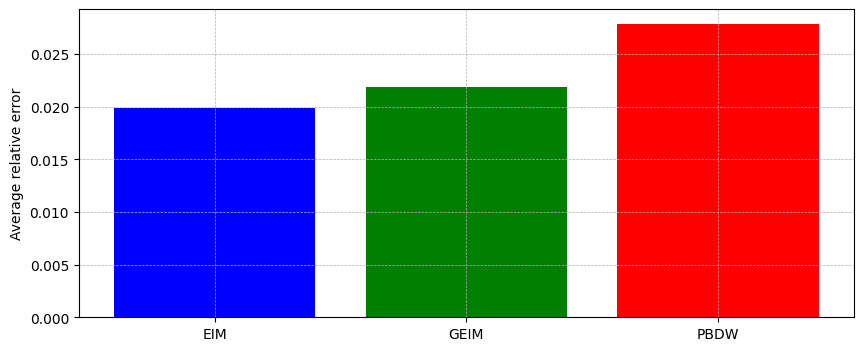

In [27]:
from pyforce.tools.backends import IntegralCalculator, LoopProgress

errors = {
    'EIM': [],
    'GEIM': [],
    'PBDW': []
}

calculator = IntegralCalculator(grid, gdim=gdim)
bar = LoopProgress(final=len(test_snaps), msg='Computing errors')

for mu, snap in enumerate(test_snaps):
    _snap_norm = calculator.L2_norm(snap)

    # EIM error
    errors['EIM'].append(
        calculator.L2_norm(snap - eim_prediction[mu]) / _snap_norm
    )

    # GEIM error
    errors['GEIM'].append(
        calculator.L2_norm(snap - geim_prediction[mu]) / _snap_norm
    )

    # PBDW error
    errors['PBDW'].append(
        calculator.L2_norm(snap - pbdw_prediction[mu]) / _snap_norm
    )

    bar.update(1)

fig, axs = plt.subplots(figsize=(10,4))
axs.bar(errors.keys(), [np.mean(errors[key]) for key in errors.keys()], 
        color=['blue', 'green', 'red'])
axs.grid(True, which='both', linestyle='--', linewidth=0.5)
axs.set_ylabel('Average relative error')

Let us make a contour plot of the estimation with respect to the true solution for a given parameter in the test set.

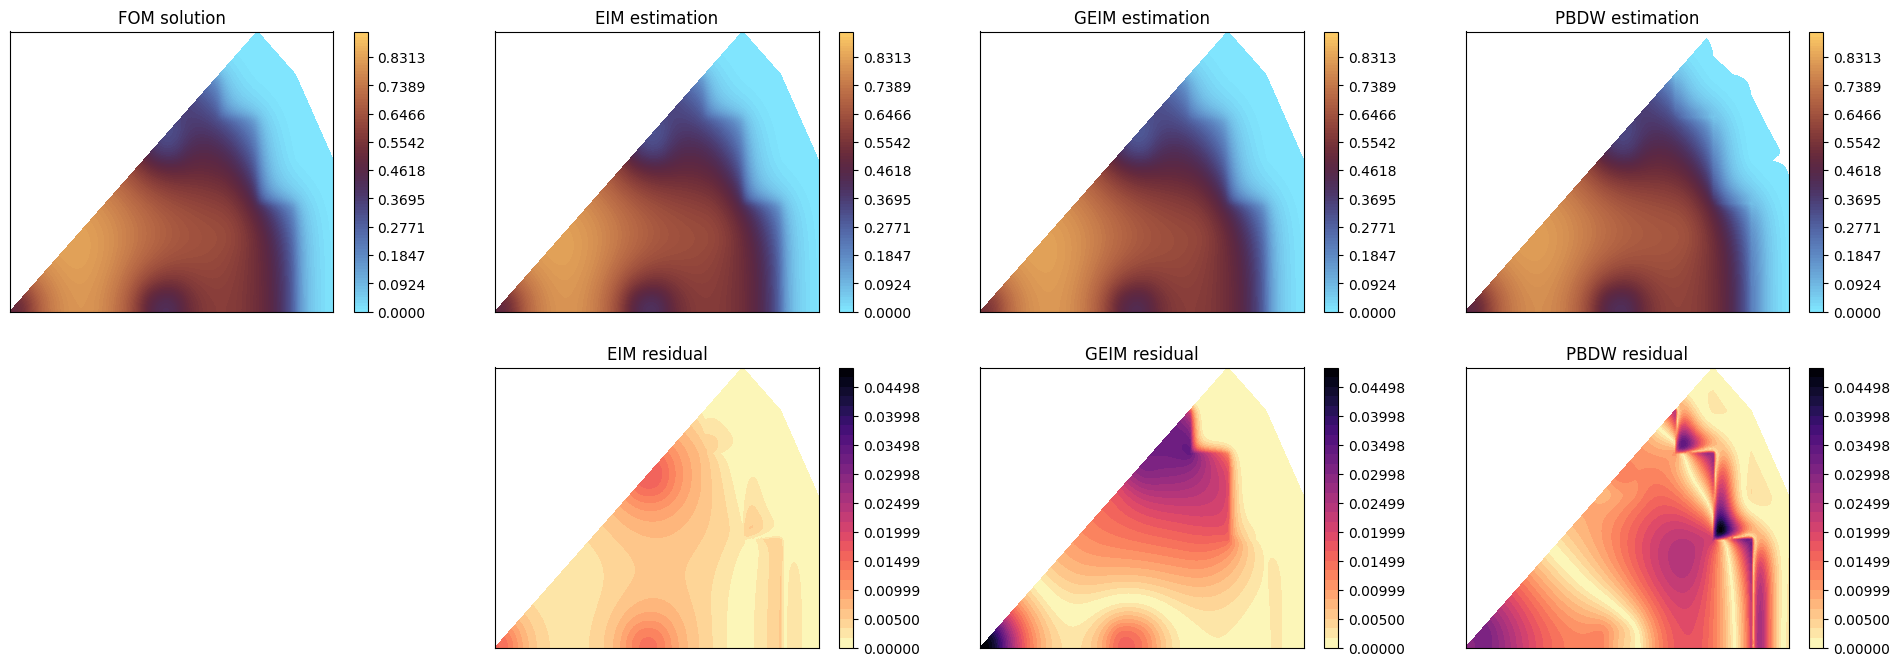

In [28]:
mu_to_plot = 5
cmap = 'managua_r'
levels = np.linspace(0, test_snaps[mu_to_plot].max()*1.1, 100)

nrows = 2
ncols = 4

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))

# FOM
c = axs[0,0].tricontourf(grid.points[:,0], grid.points[:,1], test_snaps[mu_to_plot], levels=levels, cmap=cmap)
axs[0,0].set_title('FOM solution')

# EIM
axs[0,1].tricontourf(grid.points[:,0], grid.points[:,1], eim_prediction[mu_to_plot], levels=levels, cmap=cmap)
axs[0,1].set_title('EIM estimation')

# GEIM
axs[0,2].tricontourf(grid.points[:,0], grid.points[:,1], geim_prediction[mu_to_plot], levels=levels, cmap=cmap)
axs[0,2].set_title('GEIM estimation')

# PBDW
axs[0,3].tricontourf(grid.points[:,0], grid.points[:,1], pbdw_prediction[mu_to_plot], levels=levels, cmap=cmap)
axs[0,3].set_title('PBDW estimation')

for ax in axs[0]:
    fig.colorbar(c, ax=ax)

## Residuals
res_eim = np.abs(test_snaps[mu_to_plot] - eim_prediction[mu_to_plot])
res_geim = np.abs(test_snaps[mu_to_plot] - geim_prediction[mu_to_plot])
res_pbdw = np.abs(test_snaps[mu_to_plot] - pbdw_prediction[mu_to_plot])
levels_res = np.linspace(0, max(res_eim.max(), res_geim.max(), res_pbdw.max()), 30)
cmap_res = 'magma_r'

# EIM residual
c = axs[1,1].tricontourf(grid.points[:,0], grid.points[:,1], res_eim, levels=levels_res, cmap=cmap_res)
axs[1,1].set_title('EIM residual')

# GEIM residual
c = axs[1,2].tricontourf(grid.points[:,0], grid.points[:,1], res_geim, levels=levels_res, cmap=cmap_res)
axs[1,2].set_title('GEIM residual')

# PBDW residual
c = axs[1,3].tricontourf(grid.points[:,0], grid.points[:,1], res_pbdw, levels=levels_res, cmap=cmap_res)
axs[1,3].set_title('PBDW residual')

axs[1,0].axis('off')

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axs[1,1:]:
    fig.colorbar(c, ax=ax)